<a href="https://colab.research.google.com/github/devparikh0506/DATA-603/blob/main/assignment-4/NASA_Data_Streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Kafka as described here : https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/kafka.ipynb#scrollTo=wjnM81lPROen

In [1]:
!pip install kafka-python requests cartopy

Downloading kafka

In [2]:
!curl -sSOL https://dlcdn.apache.org/kafka/3.9.0/kafka_2.13-3.9.0.tgz
!tar -xzf kafka_2.13-3.9.0.tgz

Using the default configurations (provided by Apache Kafka) for spinning up the instances.

In [3]:
!./kafka_2.13-3.9.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.9.0/config/zookeeper.properties
!./kafka_2.13-3.9.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.9.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [4]:
!ps -ef | grep kafka

root       40010   38931  0 06:53 ?        00:00:00 /bin/bash -c ps -ef | grep kafka
root       40012   40010  0 06:53 ?        00:00:00 grep kafka


Deleting any existing topic with same name. It will just print error if there is not existing topic with same name found.

In [5]:
!./kafka_2.13-3.9.0/bin/kafka-topics.sh --delete --bootstrap-server 127.0.0.1:9092 --topic iss_location

Error while executing topic command : Topic 'Optional[iss_location]' does not exist as expected
[2024-11-07 06:54:02,165] ERROR java.lang.IllegalArgumentException: Topic 'Optional[iss_location]' does not exist as expected
	at org.apache.kafka.tools.TopicCommand.ensureTopicExists(TopicCommand.java:218)
	at org.apache.kafka.tools.TopicCommand.access$700(TopicCommand.java:81)
	at org.apache.kafka.tools.TopicCommand$TopicService.deleteTopic(TopicCommand.java:656)
	at org.apache.kafka.tools.TopicCommand.execute(TopicCommand.java:113)
	at org.apache.kafka.tools.TopicCommand.mainNoExit(TopicCommand.java:90)
	at org.apache.kafka.tools.TopicCommand.main(TopicCommand.java:85)
 (org.apache.kafka.tools.TopicCommand)


In [6]:
!./kafka_2.13-3.9.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic iss_location

Created topic iss_location.


In [7]:
from kafka import KafkaProducer, KafkaConsumer
import json
import requests
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from threading import Thread
import pandas as pd
from requests.exceptions import RequestException

# ===========================================================================
# Kafka configuration
# ===========================================================================
KAFKA_TOPIC = 'iss_location'
KAFKA_SERVER = '127.0.0.1:9092'

# ===========================================================================
# API URL AND CONFIGURATIONS
# ===========================================================================
API_URL = "http://api.open-notify.org/iss-now.json"
MAX_RETRIES = 3
RETRY_DELAY = 1 # seconds

# ===========================================================================
# Streaming configurations
# ===========================================================================
INTERVAL = 5  # seconds
DURATION = timedelta(hours=1)


# ===========================================================================
# Function to fetch ISS Data
# ===========================================================================
def fetch_iss_data(max_retries=MAX_RETRIES, retry_delay=RETRY_DELAY):
  """
  Fetches ISS location data from the Open-Notify API.

  Attempts to fetch data from the API, retrying a specified number of times
  with a specified delay between retries in case of errors.

  Args:
      max_retries: The maximum number of retries to attempt. Defaults to MAX_RETRIES.
      retry_delay: The delay between retries, as a timedelta object. Defaults to RETRY_DELAY.

  Returns:
      A dictionary containing the ISS location data if successful, or None if all retries fail.
  """
  for attempt in range(max_retries):
      try:
          response = requests.get(API_URL, timeout=10)
          response.raise_for_status()
          return response.json()
      except RequestException as e:
          print(f"Attempt {attempt + 1} failed: {str(e)}")
          if attempt < max_retries - 1:
              print(f"Retrying in {retry_delay} seconds...")
              time.sleep(retry_delay)
          else:
              print("Max retries reached. Unable to fetch data.")
              return None


# ===========================================================================
# Function to run producer to collect 1hour data and stream using Kafka
# ===========================================================================
def kafka_producer():
    """
    Produces and sends ISS location data to a Kafka topic.

    Fetches ISS location data at regular intervals and sends it to a specified Kafka topic.
    The function runs for a defined duration, fetching and sending data every few seconds.

    Args:
        None

    Returns:
        None
    """
    producer = KafkaProducer(
        bootstrap_servers=[KAFKA_SERVER],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    start_time = datetime.now()
    end_time = start_time + DURATION

    while datetime.now() < end_time:
        data = fetch_iss_data()
        if data:
            producer.send(KAFKA_TOPIC, value=data)
            print(f"Sent data: {data}")
        else:
            print("Failed to fetch ISS data. Skipping this iteration.")

        time.sleep(INTERVAL)

    producer.close()
    print("Producer finished")

Let's produce the data

In [8]:
kafka_producer()

Sent data: {'timestamp': 1730962445, 'iss_position': {'latitude': '27.7900', 'longitude': '-159.3452'}, 'message': 'success'}
Sent data: {'timestamp': 1730962451, 'iss_position': {'latitude': '28.0438', 'longitude': '-159.0850'}, 'message': 'success'}
Sent data: {'timestamp': 1730962456, 'iss_position': {'latitude': '28.2739', 'longitude': '-158.8473'}, 'message': 'success'}
Sent data: {'timestamp': 1730962461, 'iss_position': {'latitude': '28.5035', 'longitude': '-158.6085'}, 'message': 'success'}
Attempt 1 failed: HTTPConnectionPool(host='api.open-notify.org', port=80): Max retries exceeded with url: /iss-now.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7d9c00d6b2b0>, 'Connection to api.open-notify.org timed out. (connect timeout=10)'))
Retrying in 1 seconds...
Attempt 2 failed: HTTPConnectionPool(host='api.open-notify.org', port=80): Max retries exceeded with url: /iss-now.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection ob

Now let's define the consumer function and plotting function

<ipython-input-9-721f45266bf1>:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_data], ignore_index=True)


Received message: {'timestamp': 1730962445, 'iss_position': {'latitude': '27.7900', 'longitude': '-159.3452'}, 'message': 'success'}
Received message: {'timestamp': 1730962451, 'iss_position': {'latitude': '28.0438', 'longitude': '-159.0850'}, 'message': 'success'}
Received message: {'timestamp': 1730962456, 'iss_position': {'latitude': '28.2739', 'longitude': '-158.8473'}, 'message': 'success'}
Received message: {'timestamp': 1730962461, 'iss_position': {'latitude': '28.5035', 'longitude': '-158.6085'}, 'message': 'success'}
Received message: {'timestamp': 1730962488, 'iss_position': {'latitude': '29.7577', 'longitude': '-157.2742'}, 'message': 'success'}
Received message: {'timestamp': 1730962493, 'iss_position': {'latitude': '29.9840', 'longitude': '-157.0278'}, 'message': 'success'}
Received message: {'timestamp': 1730962498, 'iss_position': {'latitude': '30.2098', 'longitude': '-156.7801'}, 'message': 'success'}
Received message: {'timestamp': 1730962541, 'iss_position': {'latitud

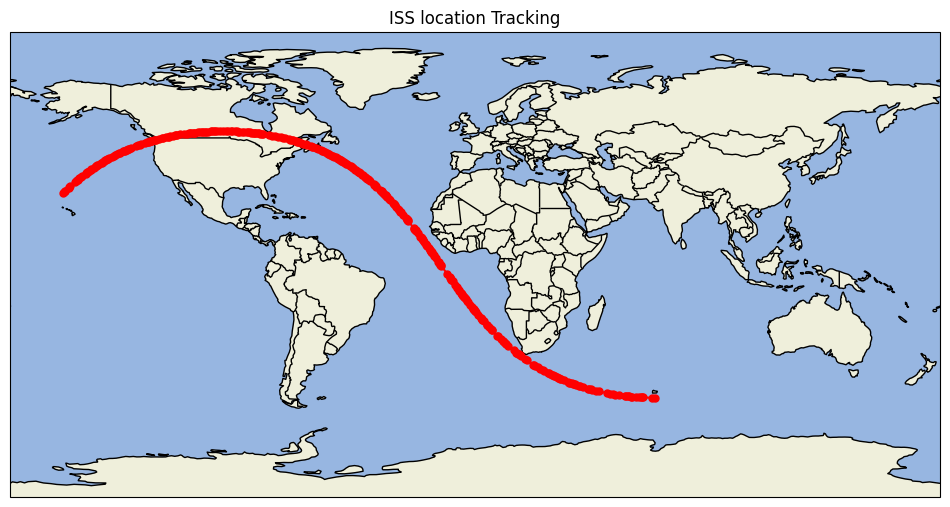

In [9]:

# ===========================================================================
# Plotting function
# ===========================================================================

def plot_iss_path(df):
    """
    Plots the path of the International Space Station (ISS) on a map.

    Takes a Pandas DataFrame containing latitude and longitude coordinates of the ISS
    and creates a map visualization showing the ISS's path over time.

    Args:
        df: A Pandas DataFrame with columns 'latitude' and 'longitude' representing
            the ISS location data.

    Returns:
        None (displays the plot)
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.set_global()

    ax.plot(df['longitude'], df['latitude'], 'ro-', transform=ccrs.Geodetic(), markersize=5)

    plt.title("ISS location Tracking")
    plt.show()

# ===========================================================================
# Kafka Consumer function
# ===========================================================================

def kafka_consumer():
    """
    Consumes ISS location data from a Kafka topic and plots the path.

    Subscribes to a specified Kafka topic, receives ISS location messages,
    stores them in a Pandas DataFrame, and visualizes the ISS path on a map.

    Args:
        None

    Returns:
        None
    """
    consumer = KafkaConsumer(
        KAFKA_TOPIC,
        bootstrap_servers=[KAFKA_SERVER],
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        auto_offset_reset='earliest',
        consumer_timeout_ms=1000,
        max_poll_interval_ms =5000
    )

    df = pd.DataFrame(columns=['latitude', 'longitude'])


    for message in consumer:
        print(f"Received message: {message.value}")

        data = message.value
        lat = float(data['iss_position']['latitude'])
        lon = float(data['iss_position']['longitude'])

        new_data = pd.DataFrame({'latitude': [lat], 'longitude': [lon]})

        df = pd.concat([df, new_data], ignore_index=True)

    plot_iss_path(df)
    print("Consumer finished")



# ===========================================================================
# Running Consumer to plot the data
# ===========================================================================
kafka_consumer()